In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

import os
import sys
sys.path.insert(0, os.path.abspath('./'))

from timeseries_util import DataUtil
from timeseries_util import VisualisationUtil
from timeseries_util import expand_window
from timeseries_util import compute_rmses

In [2]:
def load_data(from_date, to_date, path):
    data = pd.read_csv(path)
    data['ds'] = pd.to_datetime(data['rok'] * 10000 + data['mesic'] * 100 + data['den'], format='%Y%m%d')
    data['rocni_obdobi'] = data['ds'].apply(lambda x: x.quarter)
    data = data.set_index('ds')
    data = data[from_date:'2018']
    return data        

* lstm s daty zbavenými sezónosti:

In [3]:
from_date = '1961'
to_date = '2018',
data = load_data(from_date, to_date, './weather_dataset.csv')
output_filename = 'lstm_without_season_y_hat.csv'

In [4]:
diff = 365
diff_365_data = DataUtil.diff(data, diff, ['teplota_prumerna', 'teplota_maximalni', 'teplota_minimalni'])

In [5]:
normalizer = StandardScaler()
normalized_data = normalizer.fit_transform(diff_365_data)

In [6]:
last_train_date = '2017-12-31'
last_train_index = diff_365_data[:last_train_date].shape[0]
target_index = 3
timesteps = 2
features = data.shape[1]
batch_size = 2920
epochs = 150

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(timesteps, features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mae')

predictions = expand_window(normalized_data, last_train_index, target_index, model, timesteps=timesteps, batch_size=batch_size, epochs=epochs)

tyden: 0



/home/michal/miniconda3/envs/mvi_venv/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)
/home/michal/miniconda3/envs/mvi_venv/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)
/home/michal/miniconda3/envs/mvi_venv/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)
/home/michal/miniconda3/envs/mvi_venv/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)
/home/michal/miniconda3/envs/mvi_venv/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


Epoch 00045: early stopping
tyden: 1
Epoch 00051: early stopping
tyden: 2
Epoch 00040: early stopping
tyden: 3
Epoch 00024: early stopping
tyden: 4
Epoch 00021: early stopping
tyden: 5
Epoch 00023: early stopping
tyden: 6
Epoch 00090: early stopping
tyden: 7
Epoch 00040: early stopping
tyden: 8
Epoch 00024: early stopping
tyden: 9
Epoch 00061: early stopping
tyden: 10
Epoch 00031: early stopping
tyden: 11
Epoch 00030: early stopping
tyden: 12
Epoch 00036: early stopping
tyden: 13
Epoch 00023: early stopping
tyden: 14
Epoch 00040: early stopping
tyden: 15
Epoch 00035: early stopping
tyden: 16
Epoch 00065: early stopping
tyden: 17
Epoch 00062: early stopping
tyden: 18
Epoch 00024: early stopping
tyden: 19
Epoch 00036: early stopping
tyden: 20
Epoch 00025: early stopping
tyden: 21
Epoch 00045: early stopping
tyden: 22
Epoch 00030: early stopping
tyden: 23
Epoch 00021: early stopping
tyden: 24
Epoch 00033: early stopping
tyden: 25
Epoch 00029: early stopping
tyden: 26
Epoch 00037: early st

In [7]:
normalized_predictions = predictions
normalizer = StandardScaler()
normalizer.fit(diff_365_data['teplota_prumerna'].values.reshape((-1, 1)))
denormalized_predictions = normalizer.inverse_transform(normalized_predictions.reshape((-1, 1))).squeeze()
denormalized_y_train = normalizer.inverse_transform(normalized_data[:last_train_index, target_index].reshape((-1, 1))).squeeze()

diff_denormalized_y = np.append(denormalized_y_train, denormalized_predictions)
y_with_predictions = DataUtil.undiff(diff_denormalized_y, data.iloc[:, target_index], diff)
y_hat = y_with_predictions[-len(denormalized_predictions):]
y = data.iloc[-len(denormalized_predictions):, target_index]

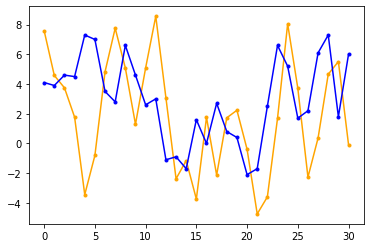

Overall mean RMSE: 4.210


In [8]:
VisualisationUtil.plot_predictions(y, y_hat, to_index=31)

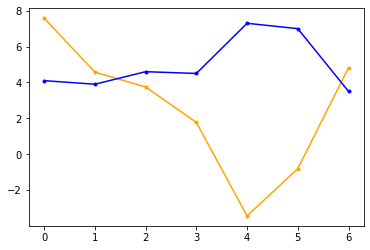

Overall mean RMSE: 5.332


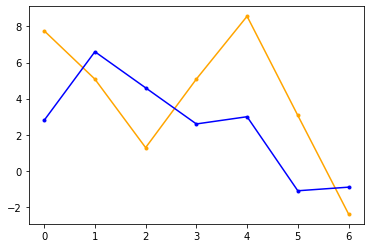

Overall mean RMSE: 3.676


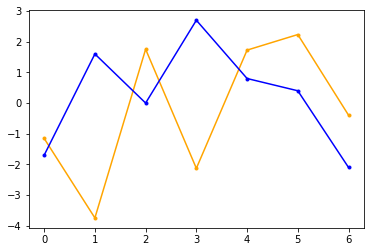

Overall mean RMSE: 2.986


In [9]:
for i in range(3):
    VisualisationUtil.plot_predictions(y, y_hat, from_index=i*7, to_index=(i*7)+7)

In [10]:
weekly_rmses = compute_rmses(y, y_hat)
np.mean(weekly_rmses)

3.366576112987765

In [11]:
pd.Series(y_hat).to_csv(output_filename, index=False, header=False)

* lstm s daty se sezóností:

In [12]:
from_date = '1961'
to_date = '2018',
data = load_data(from_date, to_date, './weather_dataset.csv')
output_filename = 'lstm_with_season_y_hat.csv'

In [13]:
normalizer = StandardScaler()
normalized_data = normalizer.fit_transform(data)

In [14]:
last_train_date = '2017-12-31'
last_train_index = data[:last_train_date].shape[0]
target_index = 3
timesteps = 5
features = data.shape[1]
batch_size = 2920
epochs = 150

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(timesteps, features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

predictions = expand_window(normalized_data, last_train_index, target_index, model, timesteps=timesteps, batch_size=batch_size, epochs=epochs)

tyden: 0


/home/michal/miniconda3/envs/mvi_venv/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)
/home/michal/miniconda3/envs/mvi_venv/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)
/home/michal/miniconda3/envs/mvi_venv/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)
/home/michal/miniconda3/envs/mvi_venv/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)
/home/michal/miniconda3/envs/mvi_venv/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


Epoch 00039: early stopping
tyden: 1
Epoch 00022: early stopping
tyden: 2
Epoch 00031: early stopping
tyden: 3
Epoch 00065: early stopping
tyden: 4
Epoch 00034: early stopping
tyden: 5
Epoch 00053: early stopping
tyden: 6
Epoch 00034: early stopping
tyden: 7
Epoch 00046: early stopping
tyden: 8
Epoch 00056: early stopping
tyden: 9
Epoch 00024: early stopping
tyden: 10
Epoch 00022: early stopping
tyden: 11
Epoch 00034: early stopping
tyden: 12
Epoch 00035: early stopping
tyden: 13
Epoch 00039: early stopping
tyden: 14
Epoch 00032: early stopping
tyden: 15
Epoch 00061: early stopping
tyden: 16
Epoch 00027: early stopping
tyden: 17
Epoch 00026: early stopping
tyden: 18
Epoch 00032: early stopping
tyden: 19
Epoch 00034: early stopping
tyden: 20
Epoch 00036: early stopping
tyden: 21
Epoch 00031: early stopping
tyden: 22
Epoch 00025: early stopping
tyden: 23
Epoch 00028: early stopping
tyden: 24
Epoch 00036: early stopping
tyden: 25
Epoch 00040: early stopping
tyden: 26
Epoch 00055: early st

In [15]:
normalized_predictions = predictions
normalizer = StandardScaler()
normalizer.fit(data['teplota_prumerna'].values.reshape((-1, 1)))
denormalized_predictions = normalizer.inverse_transform(normalized_predictions.reshape((-1, 1))).squeeze()

y_hat = denormalized_predictions
y = data.iloc[-len(denormalized_predictions):, target_index]

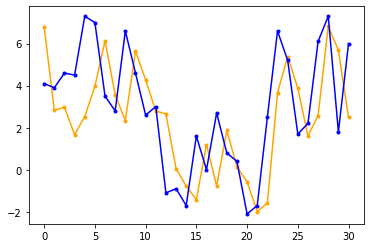

Overall mean RMSE: 2.497


In [16]:
VisualisationUtil.plot_predictions(y, y_hat, to_index=31)

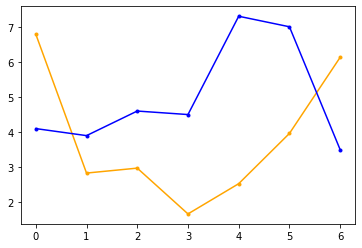

Overall mean RMSE: 2.876


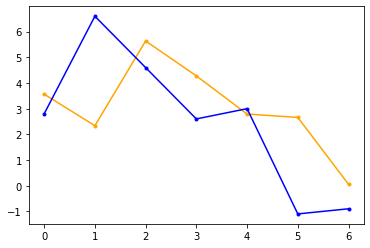

Overall mean RMSE: 2.322


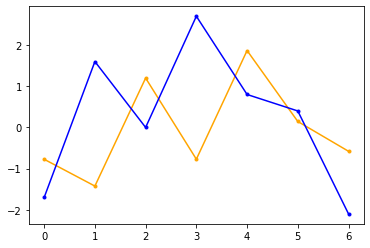

Overall mean RMSE: 1.964


In [17]:
for i in range(3):
    VisualisationUtil.plot_predictions(y, y_hat, from_index=i*7, to_index=(i*7)+7)

In [18]:
weekly_rmses = compute_rmses(y[:-1], y_hat[:-1])
np.mean(weekly_rmses)

2.2467447766105524

In [19]:
pd.Series(y_hat).to_csv(output_filename, index=False, header=False)

* MLP s daty se sezóností:

In [20]:
from_date = '1961'
to_date = '2018',
data = load_data(from_date, to_date, './weather_dataset.csv')
output_filename = 'mlp_with_season_y_hat.csv'

In [21]:
normalizer = StandardScaler()
normalized_data = normalizer.fit_transform(data)

In [22]:
last_train_date = '2017-12-31'
last_train_index = data[:last_train_date].shape[0]
target_index = 3
timesteps = 5
features = data.shape[1]
batch_size = 21169
epochs = 300

model = Sequential()
model.add(Dense(65, activation='relu', input_dim=features*timesteps))
# model.add(Dense(32, activation='relu', input_dim=features*timesteps))
# model.add(Dense(16, activation='relu', input_dim=features*timesteps))
# model.add(Dense(8, activation='relu', input_dim=features*timesteps))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mae')

predictions = expand_window(normalized_data, last_train_index, target_index, model, timesteps=timesteps, batch_size=batch_size, epochs=epochs, for_mlp=True)

tyden: 0
tyden: 1
tyden: 2
tyden: 3
tyden: 4
tyden: 5
tyden: 6
tyden: 7
tyden: 8
tyden: 9
tyden: 10
tyden: 11
tyden: 12
tyden: 13
tyden: 14
tyden: 15
tyden: 16
tyden: 17
tyden: 18
tyden: 19
tyden: 20
tyden: 21
tyden: 22
tyden: 23
tyden: 24
tyden: 25
tyden: 26
tyden: 27
tyden: 28
tyden: 29
tyden: 30
tyden: 31
tyden: 32
tyden: 33
tyden: 34
tyden: 35
tyden: 36
tyden: 37
tyden: 38
tyden: 39
tyden: 40
tyden: 41
tyden: 42
tyden: 43
tyden: 44
tyden: 45
tyden: 46
tyden: 47
tyden: 48
tyden: 49
tyden: 50
tyden: 51
tyden: 52


In [23]:
normalized_predictions = predictions
normalizer = StandardScaler()
normalizer.fit(data['teplota_prumerna'].values.reshape((-1, 1)))
denormalized_predictions = normalizer.inverse_transform(normalized_predictions.reshape((-1, 1))).squeeze()

y_hat = denormalized_predictions
y = data.iloc[-len(denormalized_predictions):, target_index]

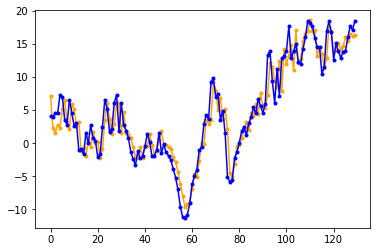

Overall mean RMSE: 2.266


In [24]:
VisualisationUtil.plot_predictions(y, y_hat, to_index=130)

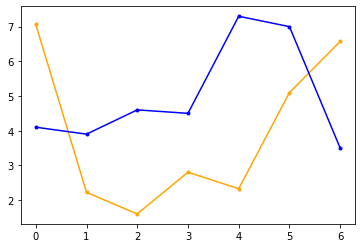

Overall mean RMSE: 2.959


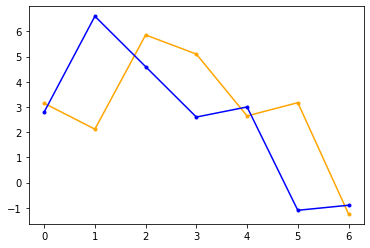

Overall mean RMSE: 2.577


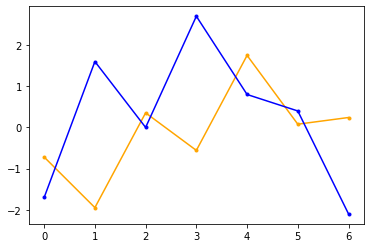

Overall mean RMSE: 2.096


In [25]:
for i in range(3):
    VisualisationUtil.plot_predictions(y, y_hat, from_index=i*7, to_index=(i*7)+7)

In [26]:
weekly_rmses = compute_rmses(y[:-1], y_hat[:-1])
np.mean(weekly_rmses)

2.0558022316328723

In [27]:
pd.Series(y_hat).to_csv(output_filename, index=False, header=False)

* MLP s daty bez sezónosti:

In [28]:
from_date = '1961'
to_date = '2018',
data = load_data(from_date, to_date, './weather_dataset.csv')
output_filename = 'mlp_without_season_y_hat.csv'

In [29]:
diff = 365
diff_365_data = DataUtil.diff(data, diff, ['teplota_prumerna', 'teplota_maximalni', 'teplota_minimalni'])

In [30]:
normalizer = StandardScaler()
normalized_data = normalizer.fit_transform(diff_365_data)

In [31]:
last_train_date = '2017-12-31'
last_train_index = diff_365_data[:last_train_date].shape[0]
target_index = 3
timesteps = 3
features = diff_365_data.shape[1]
batch_size = 20800
epochs = 300

model = Sequential()
model.add(Dense(65, activation='relu', input_dim=features*timesteps))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mae')

predictions = expand_window(normalized_data, last_train_index, target_index, model, timesteps=timesteps, batch_size=batch_size, epochs=epochs, for_mlp=True)

tyden: 0
tyden: 1
tyden: 2
tyden: 3
tyden: 4
tyden: 5
tyden: 6
tyden: 7
tyden: 8
tyden: 9
tyden: 10
tyden: 11
tyden: 12
tyden: 13
tyden: 14
tyden: 15
tyden: 16
tyden: 17
tyden: 18
tyden: 19
tyden: 20
tyden: 21
tyden: 22
tyden: 23
tyden: 24
tyden: 25
tyden: 26
tyden: 27
tyden: 28
tyden: 29
tyden: 30
tyden: 31
tyden: 32
tyden: 33
tyden: 34
tyden: 35
tyden: 36
tyden: 37
tyden: 38
tyden: 39
tyden: 40
tyden: 41
tyden: 42
tyden: 43
tyden: 44
tyden: 45
tyden: 46
tyden: 47
tyden: 48
tyden: 49
tyden: 50
tyden: 51
tyden: 52


In [32]:
normalized_predictions = predictions
normalizer = StandardScaler()
normalizer.fit(diff_365_data['teplota_prumerna'].values.reshape((-1, 1)))
denormalized_predictions = normalizer.inverse_transform(normalized_predictions.reshape((-1, 1))).squeeze()
denormalized_y_train = normalizer.inverse_transform(normalized_data[:last_train_index, target_index].reshape((-1, 1))).squeeze()

diff_denormalized_y = np.append(denormalized_y_train, denormalized_predictions)
y_with_predictions = DataUtil.undiff(diff_denormalized_y, data.iloc[:, target_index], diff)
y_hat = y_with_predictions[-len(denormalized_predictions):]
y = data.iloc[-len(denormalized_predictions):, target_index]

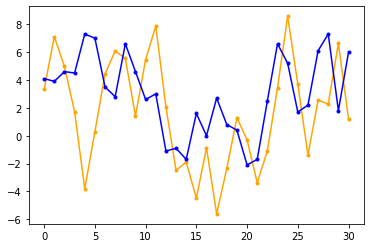

Overall mean RMSE: 4.071


In [33]:
VisualisationUtil.plot_predictions(y, y_hat, to_index=31)

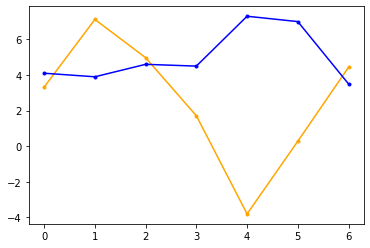

Overall mean RMSE: 5.184


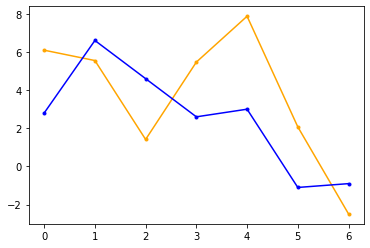

Overall mean RMSE: 3.085


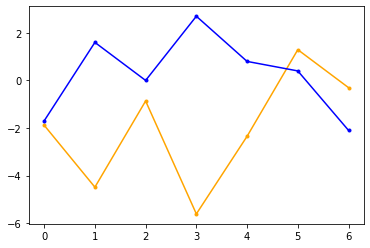

Overall mean RMSE: 4.157


In [34]:
for i in range(3):
    VisualisationUtil.plot_predictions(y, y_hat, from_index=i*7, to_index=(i*7)+7)

In [35]:
weekly_rmses = compute_rmses(y, y_hat)
np.mean(weekly_rmses)

3.3181985262727203

In [36]:
pd.Series(y_hat).to_csv(output_filename, index=False, header=False)